In [2]:
!git clone https://github.com/arcriles/TugasAkhirAI

Cloning into 'TugasAkhirAI'...
remote: Enumerating objects: 4405, done.
remote: Counting objects: 100% (4405/4405), done.
remote: Compressing objects: 100% (4369/4369), done.
remote: Total 4405 (delta 22), reused 4397 (delta 16), pack-reused 0
Receiving objects: 100% (4405/4405), 349.45 MiB | 23.12 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Checking out files: 100% (4411/4411), done.


In [4]:
%cd TugasAkhirAI/

!ls

/content/TugasAkhirAI
 50%.ipynb	     dataset		 mask_model.tflite
'aplikasi android'   face-detector.zip	 pengujian


**Face-detector.zip** merupakan file untuk melakukan pengujian model dengan menggunakan res10_300x300_ssd_iter_140000.caffemodel dan deploy.prototxt untuk mendeteksi bagian wajah

In [5]:
!unzip face-detector.zip

Archive:  face-detector.zip
  inflating: deploy.prototxt         
  inflating: example_img/ex01.jpg    
  inflating: example_img/ex02.jpg    
  inflating: example_img/ex03.jpg    
  inflating: example_img/ex04.jpg    
  inflating: example_img/ex05.jpg    
  inflating: example_img/ex06.jpg    
  inflating: example_img/ex07.jpg    
  inflating: example_img/ex08.jpg    
  inflating: example_img/ex09.jpg    
  inflating: example_img/ex10.jpg    
  inflating: res10_300x300_ssd_iter_140000.caffemodel  


## Mengimport *Library*

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import argparse
import os
import itertools

!pip install mtcnn
 
!pip install ipython-autotime
 
%load_ext autotime

     |████████████████████████████████| 2.3 MB 3.9 MB/s 
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 8.09 s (started: 2021-11-18 15:52:57 +00:00)


In [7]:
INIT_LR = 1e-4
EPOCHS = 30
BS = 32
 
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []
 
for imagePath in imagePaths:
 
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
 
    data.append(image)
    labels.append(label)
 
data = np.array(data, dtype="float32")
labels = np.array(labels)
 
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print("It Works!")

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


It Works!
time: 15.9 s (started: 2021-11-18 14:49:08 +00:00)


In [8]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
 
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

time: 870 ms (started: 2021-11-18 14:49:27 +00:00)


## Membuat Model Jaringan CNN

In [9]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 0s 0us/step
time: 7.17 s (started: 2021-11-18 14:49:32 +00:00)


### *Feature Extraction*

Menggunakan model *pre-trained* untuk ekstraksi fitur (*feature extraction*) : Ketika bekerja dengan dataset kecil, adalah umum untuk mengambil keuntungan dari fitur yang dipelajari oleh model yang dilatih pada dataset yang lebih besar dalam domain yang sama.

In [10]:
baseModel.trainable = False
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

## Tahap Pembuatan Model

In [11]:
# Membentuk bagian head dari model yang akan ditempatkan pada base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
 
# Menempatkan head model pada base model
model = Model(inputs=baseModel.input, outputs=headModel)
 
# Perulangan pada seluruh base model
for layer in baseModel.layers:
    layer.trainable = False
 
# Persiapan kompilasi model
print("Mengkompilasi model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

model.summary()

Mengkompilasi model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Melakukan Pelatihan Model

In [12]:
# Pelatihan model
print("Training head model...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Training head model...
Epoch 1/30
95/95 [==============================] - 73s 439ms/step - loss: 0.4118 - accuracy: 0.8405 - val_loss: 0.1597 - val_accuracy: 0.9817
Epoch 2/30
95/95 [==============================] - 39s 413ms/step - loss: 0.1485 - accuracy: 0.9641 - val_loss: 0.0860 - val_accuracy: 0.9804
Epoch 3/30
95/95 [==============================] - 39s 413ms/step - loss: 0.0971 - accuracy: 0.9733 - val_loss: 0.0627 - val_accuracy: 0.9804
Epoch 4/30
95/95 [==============================] - 39s 413ms/step - loss: 0.0777 - accuracy: 0.9782 - val_loss: 0.0520 - val_accuracy: 0.9857
Epoch 5/30
95/95 [==============================] - 39s 410ms/step - loss: 0.0701 - accuracy: 0.9779 - val_loss: 0.0456 - val_accuracy: 0.9857
Epoch 6/30
95/95 [==============================] - 39s 408ms/step - loss: 0.0576 - accuracy: 0.9852 - val_loss: 0.0421 - val_accuracy: 0.9857
Epoch 7/30
95/95 [==============================] - 39s 406ms/step - loss: 0.0560 - accuracy: 0.9871 - val_loss: 0.0435

### Menampilkan Kurva Hasil

tingkat akurasi


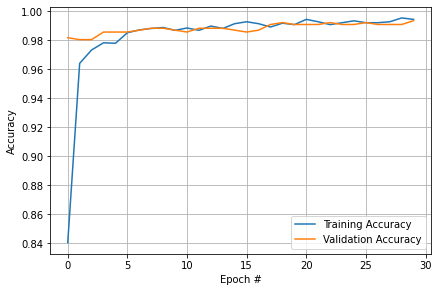

time: 297 ms (started: 2021-11-18 15:21:41 +00:00)


In [16]:
print("tingkat akurasi")
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 1)
plt.plot(np.arange(0, N), H.history["accuracy"],label = "Training Accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.grid(zorder = 0)

kurva error


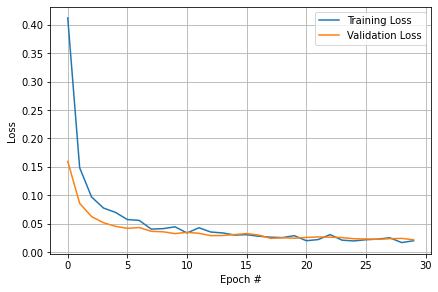

time: 231 ms (started: 2021-11-18 15:21:46 +00:00)


In [17]:
print("kurva error")
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 2)
plt.plot(np.arange(0, N), H.history["loss"],label = "Training Loss")
plt.plot(np.arange(0, N), H.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.grid(zorder = 0)
plt.show()


**yang belum dilakukan:**
1. *evaluasi training*
2. *mengekspor training untuk aplikasi mobile*
3. *test model dengan cnn (mtcnn, untuk mempermudah pekerjaan dibandingkan membuat module python dari awal.)*

3:54:20 AM, 15 November 2021 *(by: Arcriles Thungriallu)*

## Evaluasi

In [18]:
# Memeriksa matriks model
print(model.metrics_names)
# Evaluasi data test
print(model.evaluate(x= testX, y = testY))

['loss', 'accuracy']
24/24 [==============================] - 3s 113ms/step - loss: 0.0220 - accuracy: 0.9935
[0.0219969991594553, 0.9934810996055603]
time: 3.21 s (started: 2021-11-18 15:21:50 +00:00)


In [19]:
yTrue = np.argmax(testY, axis=1)

YPred = model.predict(testX, batch_size=BS)
yPred = np.argmax(YPred, axis=1)

print (yTrue)
print(yPred)

[0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0
 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1
 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0
 0 0 1 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1
 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0
 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1
 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0
 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0
 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1
 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1
 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1
 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 1
 0 1 0 1 0 1 1 1 0 0 1 1 

## Confusion Matrix

In [20]:
def get_confusion_matrix(yTrue, yPred):
    n_classes = len(np.unique(yTrue)) 
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(yTrue, yPred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

time: 3.81 ms (started: 2021-11-18 15:27:31 +00:00)


In [21]:
conf = get_confusion_matrix(yTrue, yPred)
conf

array([[381,   2],
       [  3, 381]])

time: 7.98 ms (started: 2021-11-18 15:34:11 +00:00)


Text(0.5, 15.0, 'Label Prediksi')

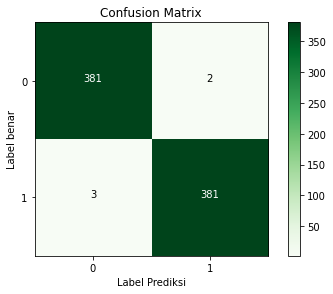

time: 321 ms (started: 2021-11-18 15:34:14 +00:00)


In [22]:
classes = [0, 1]
# Confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Label benar')
plt.xlabel('Label Prediksi')

In [23]:
TP = true_pos = 383
TN = true_neg = 382
FP = false_pos = 1
FN = false_neg = 1

time: 2.66 ms (started: 2021-11-18 15:34:18 +00:00)


In [24]:
results = {}

# Akurasi
metric = "Akurasi"
results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} = {results[metric]: .3f}")

# Recall
metric = "Recall"
results[metric] = TP / (TP + FN)
print(f"{metric} = {results[metric]: .3f}")

# Presisi
metric = "Presisi"
results[metric] = TP / (TP + FP)
print(f"{metric} = {results[metric]: .3f}")

# Nilai F1
metric = "F1"
results[metric] = 2 / (1 / results["Presisi"] + 1 / results["Recall"])
print(f"{metric} = {results[metric]: .3f}")

Akurasi =  0.997
Recall =  0.997
Presisi =  0.997
F1 =  0.997
time: 13.5 ms (started: 2021-11-18 15:34:22 +00:00)


In [26]:
# Membuat prediksi dari pengujian
predIdxs = model.predict(testX, batch_size=BS)
 
# mencari indeks dengan probabilitas terbesar
predIdxs = np.argmax(predIdxs, axis=1)
 

print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

print ("Mosi Mita! :D")

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

Mosi Mita! :D
time: 2.43 s (started: 2021-11-18 15:35:53 +00:00)


## menyimpan hasil untuk aplikasi

In [28]:
export_dir='saved_model/1'
tf.saved_model.save(model, export_dir)

# convert ke tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)


interpreter = tf.lite.Interpreter(model_content = tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

print(input_details)
print(output_details)

INFO:tensorflow:Assets written to: saved_model/1/assets


[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 181, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
time: 38 s (started: 2021-11-18 15:42:18 +00:00)


# Done

11:49:30 AM, 18 November 2021 *(by: Arcriles Thungriallu)
pure pain*